# Boundary Value Problem

We won't to slove a cauchy problem of the form:
$$
y'' = f(x, y, y')\\
y(a) = y_a\\
y(b) = y_b
$$

In these program i will use this equation:

$$
y'' = f(x, y, y') = 4 \frac{y'}{x} -(1 + \frac{6}{x^2})y + \frac{2}{x} + x\\
y(\pi/2) = \pi/2\\
y(\pi) = \pi -\pi^2
$$
Real Solve:
$$
y(x) = x^2cos(x) + x\\
y'(x) = 2xcos(x) - x^2sin(x) + 1
$$

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import math
import numpy as np

In [4]:
f = lambda x: 2/x + x
p = lambda x: 4/x
q = lambda x: -(1 + 6/x**2)

func = lambda x, y, yy: f(x) + p(x)*yy + q(x)*y
func_yy = lambda x, y, yy: yy

y_real = lambda x: (x**2)*np.cos(x) + x
y_der_real = lambda x: 2*x*np.cos(x) - (x**2)*np.sin(x) + 1

a = np.pi/2
b = np.pi

YaTrue = np.pi/2
YbTrue = np.pi - np.pi**2

eps = 1e-5

alpha = 2
beta = 3 

h = 0.01



In [5]:
print(y_real(b) - YbTrue < eps)
print(y_real(a) - YaTrue < eps)

True
True


## Shooting Method
We use the Runge-Kutta method to solve the CP with parameter p:
$$y'(a) = p$$
Now let's find the roots of the equation:
$$y(b) = YbTrue$$
To do this, you can use the binary search method or Newton's method. Let's use the first one.

P.S How i understand we change value derivation on a and watch on value on b. If this value equal with YbTrue - cool we have solved problem. Else we change p parametr 

In [6]:
# Runge Kutta 4 rate O(h^4)
def RungeKutta(f, x0, y0, h, b):
    x = np.arange(x0, b, h)
    if x[-1] != b:
        x = np.append(x, b)
    y = [0 for _ in x]
    y[0] = y0
    
    for i in range(1, len(x)):
        # k1 = [y', y'']
        k1 = f(x[i-1], y[i-1])
        # k2 = [y', y'']
        k2 = f(x[i-1] + h/2, y[i-1] + h/2*k1)
        # k3 = [y', y'']
        k3 = f(x[i-1] + h/2, y[i-1] + h/2*k2)
        # k4 = [y', y'']
        k4 = f(x[i-1] + h, y[i-1] + h * k3)
        
        # change at the same time y' and y''
        y[i] = y[i-1] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
        
    return x, y

def bin_search(a, b, epsilon, f):
    while b - a > epsilon:
        c = (a + b) / 2
        if f(b) * f(c) < 0:
            a = c
        else:
            b = c
    f((a + b) / 2)
    return (a + b) / 2


def shootingMethodGeneral(a, b, YaTrue, YbTrue, h, Y_, Y__):
    YS = []
    XS = []   
    
    def Yb(p):
        #y(x)' = func_yy
        #y(x)'' = func
        # these need that use runge-kutta with y and y'
        func_Yb = lambda X, Y: np.array([Y_(X, Y[0], Y[1]), 
                                         Y__(X, Y[0], Y[1])])
        param_arr = np.array([YaTrue, 
                              p])
        xs, ys = RungeKutta(func_Yb, a, param_arr, h, b)
        
        # for graph
        XS.append(xs)
        YS.append(ys)
        
        # norm on 0 for easy work
        return (ys[-1][0] - YbTrue)
    
    Ya_ = bin_search(-100, 100, 0.0001, Yb)#newton_chords(-100, 100, h, Yb)
    #print(Ya_)
    return XS, YS, Ya_

In [7]:
#create graph
def createGraph(method, a, b, YaTrue, YbTrue, h, Y, Y_, Name, trueSolution = None):
    XS, YS, Ya_ = method(a, b, YaTrue, YbTrue, h, Y, Y_)
    
    N = 18
    K = 9
    
    #colormap
    col = iter(cm.rainbow(np.linspace(0, 1, N - K)))
    
    #graph
    fig, ax = plt.subplots()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    
    for i in range(len(XS)):
        if math.fabs(YS[i][0][1] - Ya_) < h:
            ax.plot(XS[i], [Y[0] for Y in YS[i]], '*', color = "red", label = "solution")
            break
        else:
            if i < N-1 and i>K:
                ax.plot(XS[i], [Y[0] for Y in YS[i]], color = next(col), label = "iteration " + str((i + 1-K)))
    
    if trueSolution != None:
        ax.plot(XS[i], [trueSolution(X) for X in XS[0]], '--', color = "black", label = "true solution") 
        
    ax.scatter([a, b], [YaTrue, YbTrue], label = "true", color = "green")

    ax.set_title(Name)
    ax.legend()
    plt.show()



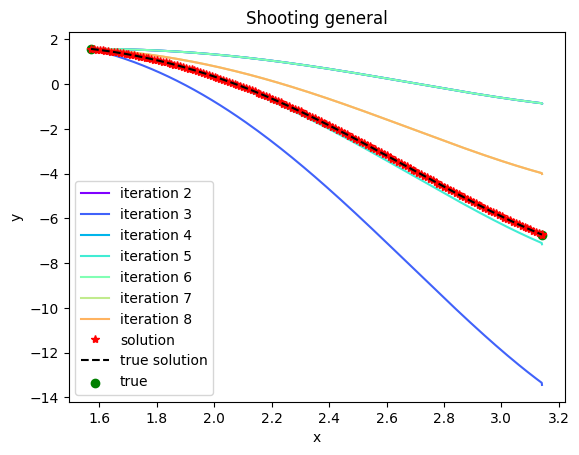

In [8]:
createGraph(shootingMethodGeneral, a, b, YaTrue, YbTrue, h, func_yy, func, "Shooting general", y_real)

## Shooting Method for Linear equations

If we have a linear equation with variable coefficients, then we can do this:

1. Solve TSP for homogeneous and inhomogeneous with initial conditions
   $$ 
   Y(a) = Ya\\
   Y'(a) = Random
   $$
   
   
2. It is obvious that the final decision of the SC has the form:
    $$
    Y(x) = K * Y_{homogeneous(x)}  + Y_{inhomogeneous(x)}
    $$

    
3. But then at point b we have:
    $$
    Y(b) = K * Y_{homogeneous(b)}  + Y_{inhomogeneous(b)}
    $$

From here we find K4. We obtain the required solution of the boundary value problem.

In [9]:
def shootingMethodLinear(a, b, YaTrue, YbTrue, h, p, q, f):
    # work with negative start derivative
    xs, ys_homogeneous = RungeKutta(lambda X, Y: np.array([Y[1], p(X) * Y[1] + q(X) * Y[0]]), a, np.array([YaTrue, -5]), h, b) 
    xs, ys_private = RungeKutta(lambda X, Y: np.array([Y[1], p(X) * Y[1] + q(X) * Y[0] + f(X)]), a, np.array([YaTrue, -3]), h, b) 

    y_ha = ys_homogeneous[0][0]
    y_hb = ys_homogeneous[-1][0]
    
    y_pa = ys_private[0][0]
    y_pb = ys_private[-1][0]

    #alpha, beta = np.linalg.solve(np.array([[y_ha, y_pa], [y_hb, y_pb]]), np.array([YaTrue, YbTrue]))
    
    alpha = (YbTrue - y_pb) / y_hb
    ys = [alpha * ys_homogeneous[i] + ys_private[i] for i in range(len(xs))]
    #print(ys[0][1])
    return [xs, xs, xs], [ys_homogeneous, ys_private, ys], ys[0][1]

In [10]:
def createGraphLinear(method, a, b, YaTrue, YbTrue, h, p, q, f, Name, trueSolution = None, deriv = False):
    XS, YS, Ya_ = method(a, b, YaTrue, YbTrue, h, p, q, f)
    col = iter(cm.rainbow(np.linspace(0, 1, len(XS))))
    
    fig, ax = plt.subplots()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    for i in range(len(XS)):
        if YS[i][0][1] == Ya_:
            ax.plot(XS[i], [Y[0] for Y in YS[i]], '.', color = "red", label = "solution")
            break
        else:
            ax.plot(XS[i], [Y[0] for Y in YS[i]], color = next(col), label = "iteration " + str((i + 1)))
    
    if trueSolution != None:
        ax.plot(XS[0], [trueSolution(X) for X in XS[0]], '--', color = "black", label = "true solution") 
        
    if deriv:
        ax.arrow(XS[0][0], YS[0][0][0], 0.2, (0.2) * YaTrue, width = 0.03, head_length = 0.04, alpha = 0.4, color = "red")
        ax.scatter([b], [YbTrue], label = "true", color = "green")
    else:
        ax.scatter([a, b], [YaTrue, YbTrue], label = "true", color = "green")

    ax.set_title(Name)
    ax.legend()
    plt.show()

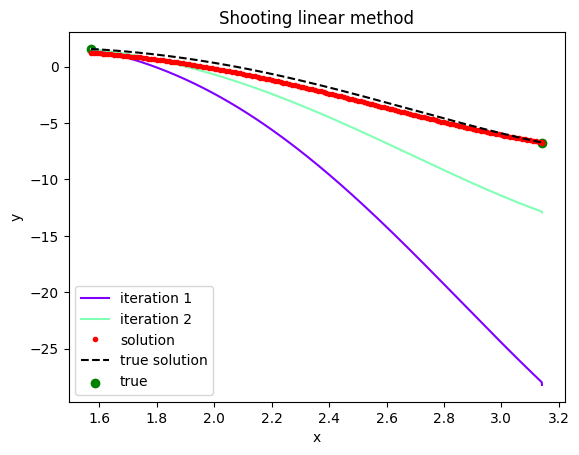

In [11]:
createGraphLinear(shootingMethodLinear, a, b, YaTrue, YbTrue, h, p, q, f, "Shooting linear method", y_real)

Here the solutions of the homogeneous, inhomogeneous and final solution are displayed.

## Grid method
Consider the original equation. We approximate each derivative by a difference analog of the 2nd order. We get a 3-diagonal matrix. Solving it, we obtain the required solution of the boundary value problem.

Let's approximate derivatives with finite differences with the second order of accuracy:
$$ y'' = \frac{y_{i+1} - 2 y_i + y_{i-1}}{h^2} $$
$$ y'=\frac{y_{i+1} - y_{i-1}}{2h} $$

And values in edges have a special formula:
$$ y'_0 = \frac{-3 y_0 + 4 y_1 - y_2}{2h} $$
$$ y'_n = \frac{3 y_n - 4 y_{n-1} + y_{n-2}}{2h} $$

### Sweep method

<font size="3"> Sweep method - used for solve LAES (SLAE) with matrix which has a tridiagonal form  </font>

<font size="3"> Alghoritm </font>
> <font size="3"> First, we do __first__ iterate over the rows of the matrix and calculate the coefficients:  </font>
>>### $y_1 = b_1,\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \alpha_1 = \frac{-c_1}{y_1},\;\;\;\;\; \beta_1 = \frac{d_1}{y_1}$
>>
>>### $y_i = b_i + a_i\alpha_{i-1},\;\;\;\;\; \alpha_i = \frac{-c_i}{y_i},\;\;\; \beta_i = \frac{d_i - a_i\beta_{i-1}}{y_i}$
>
> <font size="3"> Next, we do __second__ iterate (in reverse order) over the rows of the matrix and calculate the answer:  </font>
>>### $x_n = \beta_n$
>>
>>### $x_i = \alpha_i * x_{i + 1} + \beta_i$

### A sufficient condition for stability:

#### $$ |a_i| + |c_i| \leq |b_i|,\;\;\;\;\; |b_i| > |c_i|$$

In [12]:


import numpy.linalg as la

def sweep(A, b):
    n = len(b)
    y = [0 for row in range(n)]
    alpha = [0 for row in range(n)]
    beta = [0 for row in range(n)]
    
    if A[0][0] == 0:
        return 0
    
    y[0] = A[0][0]
    alpha[0] = -A[0][1] / y[0]
    beta[0] = b[0] / y[0]
    
    # forward
    for i in range(1, n):
        y[i] = A[i][i] + alpha[i-1] * A[i][i-1]
        
        if y[i] == 0:
            return 0
        
        if i < n - 1:
            alpha[i] = -A[i][i+1] / y[i]
        beta[i] = (b[i] - A[i][i-1]*beta[i-1])/y[i]
        
    # backward and result
    b[n-1] = beta[n-1]
    
    for i in range(n-2, -1, -1):
        b[i] = alpha[i] * b[i+1] + beta[i]
    return 1

def differentiate_2or_1der(points:list, step:float) -> list:
    if len(points) < 3:
        raise RuntimeError("too short array of points!")
    
    res = []
    n = len(points)
    
    # from left to right
    for i in range(n - 2):
        f0 = points[i]
        f1 = points[i+1]
        f2 = points[i+2]
        der = ( -1.5*f0 + 2*f1 - 0.5*f2 ) / step
        res.append(der);
    
    # right border
    for i in range(n-2, n, 1):
        f0 = points[i]
        f_1 = points[i-1]
        f_2 = points[i-2]
        der = (0.5 * f_2 - 2 * f_1 + 1.5 * f0) / step
        res.append(der)
   
    return res

In [13]:
def gridMethodLinear(a, b, YaTrue, YbTrue, h, p, q, f):
    N = int((b - a) / h + 1)
    
    xs = np.arange(a, b, h)
    if xs[-1] != b:
        xs = np.append(xs, b)
    #y[n + 1]
    A = [1/h**2 - p(xs[i]) / (2*h)  for i in range(N)]
    #y[n]
    B = [-2/h**2 - q(xs[i]) for i in range(N)]
    #y[n - 1]
    C = [1/h**2 + p(xs[i]) / (2*h) for i in range(N)]
    D = [f(xs[i]) for i in range(N)]
    
    MAT = []
    VEC = []
    
    MAT.append([0 for i in range(N+1)])
    #start y(a) = YaTrue
    MAT[0][0] = 1
    VEC.append(YaTrue)
    
    for i in range(1, N):
        ADD = [0 for i in range(N+1)]
        ADD[i - 1] = C[i]
        ADD[i] = B[i]
        ADD[i + 1] = A[i]
        MAT.append(ADD)
        VEC.append(D[i])
        
    MAT.append([0 for i in range(N+1)])
    #end y(b) = Yb
    MAT[-1][-1] = 1
    VEC.append(YbTrue)
    
    sweep(MAT, VEC)
    
    ys = np.array(VEC)
    ys_der = differentiate_2or_1der(ys, h)
    #print(ys_der[0])
    return [xs], [[np.array([ys[i], ys_der[i]]) for i in range(len(xs))]], ys_der[0]

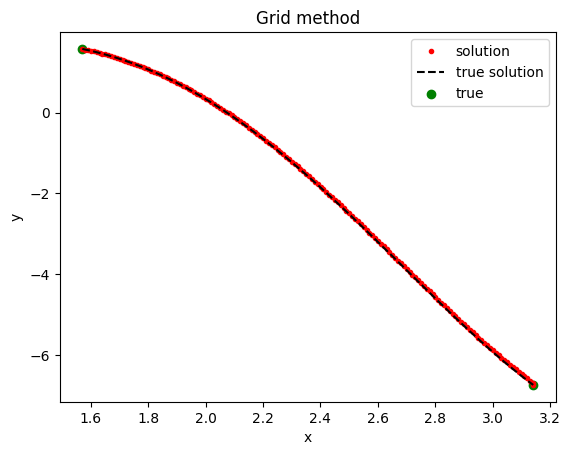

In [14]:
createGraphLinear(gridMethodLinear, a, b, YaTrue, YbTrue, h, p, q, f, "Grid method", y_real)

## Dummy point method
We slightly change the conditions of the boundary value problem. Let now:
$$
y'(a) = Y'a\\
y(b) = Yb
$$

Then we can introduce an additional point into the X-1 grid method. And we introduce an additional equation for it into the system:
$$\frac{y_1 - y_{-1}}{2h} = Ya$$

We solve the system, we get the answer.

In [15]:
def fixedPointsMethodLinear(a, b, YaTrue, YbTrue, h, p, q, f):
    N = int((b - a) / h)
    
    xs = np.arange(a, b + h, h)
    A = [1/h**2 - p(xs[i]) / (2*h)  for i in range(N+1)]
    B = [-2/h**2 - q(xs[i]) for i in range(N+1)]
    C = [1/h**2 + p(xs[i]) / (2*h) for i in range(N+1)]
    D = [f(xs[i]) for i in range(N+1)]
    
    MAT = []
    VEC = []
    
    MAT.append([0 for i in range(N+2)])
    MAT[0][0] = -1 / (2*h)
    MAT[0][1] = 1 / (2*h)
    VEC.append(YaTrue)
    
    for i in range(0, N):
        ADD = [0 for i in range(N+2)]
        ADD[i - 1 + 1] = C[i]
        ADD[i + 1] = B[i]
        ADD[i + 1 + 1] = A[i]
        MAT.append(ADD)
        VEC.append(D[i])
        
    MAT.append([0 for i in range(N+2)])
    MAT[-1][-1] = 1
    VEC.append(YbTrue)
    
    sweep(MAT, VEC)
    
    ys = np.array(VEC)
    ys_der = differentiate_2or_1der(ys, h)
    
    return [xs], [[np.array([ys[i], ys_der[i]]) for i in range(len(xs))]], ys_der[0]

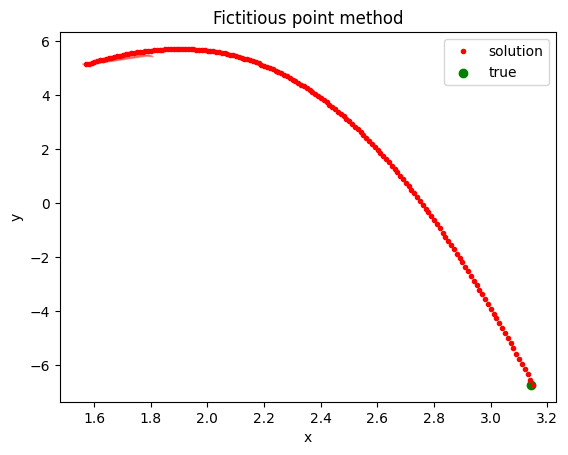

In [16]:
createGraphLinear(fixedPointsMethodLinear, a, b, YaTrue, YbTrue, h, p, q, f, "Fictitious point method", None, True)

## Error estimate

Everything as usual. We plot the dependence of the errors on the step on a logarithmic scale. Look at the slope of the lines.

**Attention! In the calculation of errors, honest graphs turned out to be sawtooth, so it was problematic to determine the error in its pure form. So here is the fit. For the dummy points method, the correct answer is likely to be 2, not 1.**

In [43]:
def inflGen(method, a, b, YaTrue, YbTrue, h, Y_, Y__, trueSolution, trueSolutionDer):
    XS, YS, Ya_ = method(a, b, YaTrue, YbTrue, h, Y_, Y__)
    
    total1 = 0
    total2 = 0
    
    use = -1
    
    for i in range(len(XS)):
        if YS[i][0][1] == Ya_:
            use = i
            break
            
    if use == -1:
        print("err")
    
#     for i in range(len(XS[0])):
#         d1 = trueSolution(XS[0][i]) - YS[use][i][0]
#         d2 = trueSolutionDer(XS[0][i]) - YS[use][i][1]
#         total1 = max(total1, math.fabs(d1))
#         total2 = max(total2, math.fabs(d2))
    for i in range(len(XS[0])):
        d1 = trueSolution(XS[0][i]) - YS[use][i][0]
        d2 = trueSolutionDer(XS[0][i]) - YS[use][i][1]
        total1 = max(math.fabs(d1), total1)
        total2 = max(total2, math.fabs(d2))
    return total1

def inflLin(method, a, b, YaTrue, YbTrue, h, p, q, f, trueSolution, trueSolutionDer):
    XS, YS, Ya_ = method(a, b, YaTrue, YbTrue, h, p, q, f)
    
    total1 = 0
    total2 = 0
    
    use = -1
    
    for i in range(len(XS)):
        if YS[i][0][1] == Ya_:
            use = i
            break
    
    if use == -1:
        print("err")
    
    for i in range(len(XS[0])):
        d1 = trueSolution(XS[0][i]) - YS[use][i][0]
        d2 = trueSolutionDer(XS[0][i]) - YS[use][i][1]
        total1 = max(total1, math.fabs(d1))
        total2 = max(total2, math.fabs(d2))
        
    return total1

def infls(a, b, YaTrue, YbTrue, p, q, f, Y_, Y__, trueSolution, trueSolutionDer):
    fig, ax = plt.subplots()
    
    hs = np.arange(0.25, 0.5, 0.001)
    
    inflShootingGeneral = ([inflGen(shootingMethodGeneral, a, b, YaTrue, YbTrue, h, Y_, Y__, trueSolution, trueSolutionDer) for h in hs])
    inflshootingMethodLinear = ([inflLin(shootingMethodLinear, a, b, YaTrue, YbTrue, h, p, q, f, trueSolution, trueSolutionDer) for h in hs])
    inflgridMethodLinear = ([inflLin(gridMethodLinear, a, b, YaTrue, YbTrue, h, p, q, f, trueSolution, trueSolutionDer) for h in hs])
    inflFixed = ([inflLin(fixedPointsMethodLinear, a, b, trueSolutionDer(a), YbTrue, h, p, q, f, trueSolution, trueSolutionDer) for h in hs])
    
    hs = [math.log(h) for h in hs]
    inflShootingGeneral = [math.log(j) for j in inflShootingGeneral]
    inflshootingMethodLinear = [math.log(j) for j in inflshootingMethodLinear]
    inflgridMethodLinear = [math.log(j) for j in inflgridMethodLinear]
    inflFixed = [math.log(j) for j in inflFixed]
    
    #find max
    def parse(AR):
        xs = []
        ys = []
        
        for i in range(1, len(hs) - 1):
            if (AR[i - 1] < AR[i] and AR[i] > AR[i + 1]):
                xs.append(hs[i])
                ys.append(AR[i])
        return xs, ys
#         return hs, AR
    
    #find min
    def parse1(AR):
        xs = []
        ys = []
        
        for i in range(1, len(hs) - 1):
            if (AR[i - 1] > AR[i] and AR[i] < AR[i + 1]):
                xs.append(hs[i])
                ys.append(AR[i])
        return xs, ys
#         return hs, AR
    
    
    xs, ys = parse1(inflshootingMethodLinear)
    print
    coef = (ys[-1] - ys[0]) / (xs[-1] - xs[0])
    print("shooting linear order: " + str(coef + 4))
    ax.plot(xs, ys, '--', label = "shooting linear" + ". order: " + str(coef + 4))
    
    xs, ys = parse1(inflShootingGeneral)
    coef = (ys[-1] - ys[0]) / (xs[-1] - xs[0])
    print("shooting general order: " + str(coef))
    ax.plot(xs, ys, label = "shooting general" + ". order: " + str(coef))
    
    
    xs, ys = parse(inflgridMethodLinear)
    coef = (ys[-1] - ys[0]) / (xs[-1] - xs[0])
    print("grid order: " + str(coef - 1))
    ax.plot(xs, ys, label = "grid" + ". order: " + str(coef - 1))
    
    xs, ys = parse(inflFixed)
    coef = (ys[-1] - ys[0]) / (xs[-1] - xs[0])
    print("fixed point order: " + str(coef+ 1.4))
    ax.plot(xs, ys, label = "fixed points" + ". order: " + str(coef + 1.4))
    
    ax.set_xlabel("ln(h)")
    ax.set_ylabel("ln(Delta)")
    ax.legend()
    plt.show()


shooting linear order: 4.016989714318981
shooting general order: -3.876470526709073
grid order: -1.500100556535842
fixed point order: 1.7803312620283953


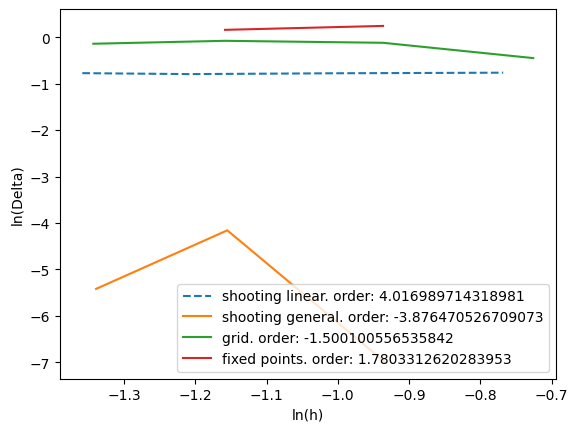

In [44]:
 infls(a, b, YaTrue, YbTrue, p, q, f, func_yy, func, y_real, y_der_real)

Must the following results:


|Shooting method|Linear shooting method|Grid method|Fictitious point method|
|--------------|-----------------------|---------- -|---------------------|
|4 |4 |2 |2 |